Strategy Sharpe Ratio: 0.6810102704281306


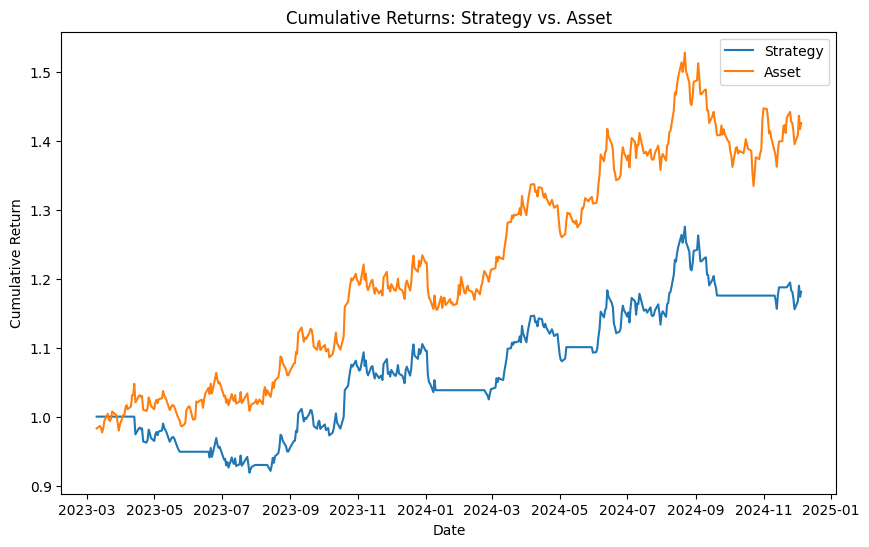

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Create synthetic daily price data (e.g., for 2 years ~504 trading days)
days = 504
# Simulate daily returns with a small drift and some volatility
daily_returns = np.random.normal(0.0005, 0.01, days)
price = 100 * np.cumprod(1 + daily_returns)
dates = pd.date_range(start="2023-01-01", periods=days, freq='B')
df = pd.DataFrame({"Price": price}, index=dates)

# Compute the moving averages
df["SMA10"] = df["Price"].rolling(window=10).mean()
df["SMA50"] = df["Price"].rolling(window=50).mean()

# Generate trading signals:
# Signal = 1 if SMA10 > SMA50 (indicating a potential uptrend)
df["Signal"] = 0
df.loc[df["SMA10"] > df["SMA50"], "Signal"] = 1

# Calculate daily asset returns
df["Asset_Return"] = df["Price"].pct_change()

# Compute strategy returns:
# We use the previous day's signal (i.e., shift by one) to decide the position today.
df["Strategy_Return"] = df["Signal"].shift(1) * df["Asset_Return"]

# Drop rows with NaN values (from rolling calculations and shifting)
df.dropna(inplace=True)

# Define a function to calculate the Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0.0, periods=252):
    """
    Calculate the annualized Sharpe Ratio.
    
    Parameters:
      returns : np.array
          Array of periodic returns.
      risk_free_rate : float, optional
          Annual risk-free rate (default: 0.0).
      periods : int, optional
          Number of periods per year (252 for daily).
          
    Returns:
      float: The annualized Sharpe Ratio.
    """
    # Convert annual risk-free rate to per-period rate
    risk_free_per_period = risk_free_rate / periods
    
    # Calculate excess returns
    excess_returns = returns - risk_free_per_period
    
    # Mean and standard deviation of excess returns
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns)
    
    # Annualize the mean excess return and the standard deviation
    annualized_return = mean_excess_return * periods
    annualized_std = std_excess_return * np.sqrt(periods)
    
    # Calculate and return the Sharpe Ratio
    return annualized_return / annualized_std

# Calculate the Sharpe Ratio for the strategy assuming a 1% annual risk-free rate
strategy_sharpe = sharpe_ratio(df["Strategy_Return"].values, risk_free_rate=0.01, periods=252)
print("Strategy Sharpe Ratio:", strategy_sharpe)

# Plot the cumulative returns for both the strategy and the underlying asset for comparison
df["Cumulative_Strategy_Return"] = (1 + df["Strategy_Return"]).cumprod()
df["Cumulative_Asset_Return"] = (1 + df["Asset_Return"]).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(df.index, df["Cumulative_Strategy_Return"], label="Strategy")
plt.plot(df.index, df["Cumulative_Asset_Return"], label="Asset")
plt.title("Cumulative Returns: Strategy vs. Asset")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()
